<a href="https://colab.research.google.com/github/a1441/BART_Code/blob/main/BART_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [178]:
from google.colab import drive
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from scipy.stats import gmean, norm, kstest
from sklearn.preprocessing import MinMaxScaler

# Data Loading

In [179]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [180]:
df_1 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults (1).xlsx', engine='openpyxl')
df_2 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults-retest.xlsx', engine='openpyxl')
df_3 = pd.read_excel(r'/content/drive/MyDrive/risktaskResults.xlsx', engine='openpyxl')

In [181]:
def process_and_transform(dfs):

    # Function to process each set of features
    def process_features(df, feature_regex, transform_func, new_col_prefix):
        df_filtered = df.filter(regex=feature_regex)
        df_transformed = transform_func(df_filtered)
        df_transformed.columns = [f'{new_col_prefix}_{x}' for x in range(1, 51)]
        return df_transformed

    # Transformation functions
    def divide_and_fill(df): return (df / 0.25).fillna(0).astype(int)
    def fill_and_int(df): return df.fillna(0).astype(int)
    def fill_replace_and_int(df): return df.fillna(0).replace(0, 3).astype(int)
    def add_one_and_fill(df): return (df.fillna(0).astype(int) + 1)

    # Initialize empty lists to hold processed DataFrames for each feature set
    collected, fallen, pumps, totals, turns, baggs = ([] for _ in range(6))

    # Process each DataFrame in the list
    for df in dfs:
        collected.append(process_features(df, 'collected|Collected', divide_and_fill, 'collected'))
        fallen.append(process_features(df, 'haveFallen|HaveFallen', fill_and_int, 'haveFallen'))
        pumps.append(process_features(df, 'pumps|Pumps', fill_and_int, 'pumps'))
        totals.append(process_features(df, 'total|Total', divide_and_fill, 'total'))
        turns.append(process_features(df, 'trialNumber|TrialNumber', add_one_and_fill, 'turn'))
        baggs.append(process_features(df, 'type|Type', fill_replace_and_int, 'bag'))

    # Concatenate all processed features
    df_start = pd.concat([pd.concat(feature_set) for feature_set in [collected, fallen, pumps, totals, turns, baggs]], axis=1)
    df_start.reset_index(drop=True, inplace=True)
    df_start['Id'] = df_start.index

    return df_start


In [182]:
df_list = [df_1, df_2, df_3]
result_df = process_and_transform(df_list)

In [183]:
result_df

,collected_1,collected_2,collected_3,collected_4,collected_5,collected_6,collected_7,collected_8,collected_9,collected_10,...,bag_42,bag_43,bag_44,bag_45,bag_46,bag_47,bag_48,bag_49,bag_50,Id
0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,0
1,0,3,4,0,2,3,3,4,3,3,...,2,2,2,2,2,2,2,2,2,1
2,0,0,0,0,0,0,0,0,6,9,...,2,2,2,2,2,2,2,2,2,2
3,0,3,4,0,0,2,2,2,2,3,...,2,2,2,2,2,2,2,2,2,3
4,0,3,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,18,0,10,16,0,0,17,0,0,0,...,2,2,2,2,2,2,2,2,2,1265
1266,14,0,8,0,9,0,0,0,1,1,...,2,2,2,2,2,2,2,2,2,1266
1267,1,1,1,1,2,2,2,2,2,4,...,2,2,2,2,2,2,2,2,2,1267
1268,0,0,0,17,0,0,17,0,16,16,...,2,2,2,2,2,2,2,2,2,1268


# ETL

In [184]:
class HeuristicFilterTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the custom filtering rules sequentially
        players_with_non_zero_count_gt_1 = self.filter_non_zero_collected(X)
        players_with_fallen_count_lt_40 = self.filter_fallen_count(X)
        players_with_pump_sum_gt_1 = self.filter_pump_sum(X)

        # Get the intersection of all player ID sets
        valid_players = set(players_with_non_zero_count_gt_1) & set(players_with_fallen_count_lt_40) & set(players_with_pump_sum_gt_1)

        # Return only the rows corresponding to the valid players
        return X[X['Id'].isin(valid_players)]

    def filter_non_zero_collected(self, df):
        counts = df.groupby('Id').apply(lambda x: x.filter(regex='collected').apply(lambda y: (y != 0).sum()).sum())
        return counts[counts > 5].index.tolist()

    def filter_fallen_count(self, df):
        counts = df.groupby('Id').apply(lambda x: x.filter(regex='Fallen').apply(lambda y: (y == 1).sum()).sum())
        return counts[counts < 40].index.tolist()

    def filter_pump_sum(self, df):
        sums = df.groupby('Id').apply(lambda x: x.filter(regex='pump').sum(axis=1).sum())
        return sums[sums > 50].index.tolist()


In [185]:
class PlayerFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting process needed as it's a stateless transformation
        return self

    def transform(self, X):
        # Assuming X is a DataFrame containing all player data
        players = X['Id'].unique()
        all_players = [self.generate_full_player_features(X[X['Id'] == player]) for player in tqdm(players)]
        full_combo = pd.concat(all_players)
        return full_combo

    def clean_turns(self, temp_dfs):
        temp_dfs = temp_dfs.copy()
        temp_dfs.columns = ['Id', 'collected', 'haveFallen', 'pumps', 'total', 'turn', 'bag']
        temp_dfs['single_turn'] = 1 if temp_dfs.pumps.values[0] == 0 else 0
        return temp_dfs

    def generate_clicks(self, sample_dfs):
        if sample_dfs.single_turn.values[0] == 1:
            sample_dfs['haveWon'] = 0
            sample_dfs['haveFallen'] = 0
            return sample_dfs
        elif sample_dfs.single_turn.values[0] == 0:
            sample_dfs = pd.concat([sample_dfs] * sample_dfs.pumps.values[0]).reset_index(drop=True)
            sample_dfs['pumps'] = range(1, sample_dfs.pumps.values[0] + 1)
            sample_dfs['haveFallen'] = [0] * (sample_dfs.pumps.max() - 1) + [sample_dfs.haveFallen.max()]
            sample_dfs['haveWon'] = [0] * (sample_dfs.pumps.max() - 1) + [-sample_dfs.haveFallen.max() + 1]
            sample_dfs['collected'] = [0] * (sample_dfs.pumps.max() - 1) + [(-sample_dfs.haveFallen.max() + 1) * sample_dfs['collected'].max()]
            return sample_dfs

    def generate_full_player_features(self, df_player_n):
        try:
            player_stratified = [df_player_n[['Id', f'collected_{t}', f'haveFallen_{t}', f'pumps_{t}', f'total_{t}', f'turn_{t}', f'bag_{t}']] for t in range(1, 51)]
            player_turns_cleaned = [self.clean_turns(p) for p in player_stratified]
            player_clicks_generated = [self.generate_clicks(c) for c in player_turns_cleaned]
            one_player_raw = pd.concat(player_clicks_generated)
            one_player_raw.reset_index(drop=True, inplace=True)
            one_player = pd.concat([one_player_raw, pd.get_dummies(one_player_raw, columns=['bag'])[['bag_1', 'bag_2', 'bag_3']]], axis=1)

            # Feature engineering
            one_player['pumps_won'] = one_player['collected'].cumsum().shift(1).fillna(0).astype(int)
            one_player['cummulative_clicks'] = one_player.index.values + 1
            one_player['pumps_lost'] = (one_player['haveFallen'] * one_player['pumps']).cumsum().shift(1).fillna(0).astype(int)
            #all bags that the player won by having haveWon more than 0
            one_player['bags_won'] = one_player['haveWon'].cumsum().shift(1).fillna(0).astype(int)

            #all bags that the player won by having haveFallen more than 0
            one_player['bags_lost'] = one_player['haveFallen'].cumsum().shift(1).fillna(0).astype(int)

            #all bags that the player won by having haveFallen more than 0
            one_player['bags_auto_lost_won0'] = one_player['single_turn'].cumsum().shift(1).fillna(0).astype(int)

            #average pumps won/lost over bags that were won/lost
            one_player['avg_pumps_per_bag_won'] = (one_player['pumps_won'] / one_player['bags_won']).fillna(0) #classic kpi
            one_player['avg_pumps_per_bag_lost'] = (one_player['pumps_lost'] / one_player['bags_lost']).fillna(0)
            one_player['avg_pumps_per_bag'] = (one_player['cummulative_clicks'] / one_player['turn']).fillna(0)


            #seperate bags stats

            #####################################################################

            one_player['bag1_won'] = (one_player['haveWon']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag1_lost'] = (one_player['haveFallen']*one_player['bag_1'] ).cumsum().shift(1).fillna(0).astype(int)

            one_player['bag1_win_vs_all'] = (one_player['bag1_won'] / one_player['bags_won']).fillna(0)
            one_player['bag1_loss_vs_all'] = (one_player['bag1_lost'] / one_player['bags_lost'] ).fillna(0)

            one_player['bag1_pumps_won'] = (one_player['bag_1'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag1_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_1']).cumsum().shift(1).fillna(0).astype(int)

            one_player['avg_pumps_per_bag1_won'] = (one_player['bag1_pumps_won'] / one_player['bag1_won']).fillna(0)
            one_player['avg_pumps_per_bag1_lost'] = (one_player['bag1_pumps_lost'] / one_player['bag1_lost']).fillna(0)

            one_player['cummulative_pumps_bag1'] = one_player['bag_1'].cumsum().fillna(0)

            #####################################################################

            one_player['bag2_won'] = (one_player['haveWon']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag2_lost'] = (one_player['haveFallen']*one_player['bag_2'] ).cumsum().shift(1).fillna(0).astype(int)

            one_player['bag2_win_vs_all'] = (one_player['bag2_won'] / one_player['bags_won'] ).fillna(0)
            one_player['bag2_loss_vs_all'] = (one_player['bag2_lost'] / one_player['bags_lost'] ).fillna(0)

            one_player['bag2_pumps_won'] = (one_player['bag_2'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag2_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_2']).cumsum().shift(1).fillna(0).astype(int)

            one_player['avg_pumps_per_bag2_won'] = (one_player['bag2_pumps_won'] / one_player['bag2_won']).fillna(0)
            one_player['avg_pumps_per_bag2_lost'] = (one_player['bag2_pumps_lost'] / one_player['bag2_lost']).fillna(0)

            one_player['cummulative_pumps_bag2'] = one_player['bag_2'].cumsum().fillna(0)

            #####################################################################

            one_player['bag3_won'] = (one_player['haveWon']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag3_lost'] = (one_player['haveFallen']*one_player['bag_3'] ).cumsum().shift(1).fillna(0).astype(int)

            one_player['bag3_win_vs_all'] = (one_player['bag3_won'] / one_player['bags_won']).fillna(0)
            one_player['bag3_loss_vs_all'] = (one_player['bag3_lost'] / one_player['bags_lost']).fillna(0)

            one_player['bag3_pumps_won'] = (one_player['bag_3'] * one_player.collected).cumsum().shift(1).fillna(0).astype(int)
            one_player['bag3_pumps_lost'] = (one_player['haveFallen'] * one_player['pumps'] * one_player['bag_3']).cumsum().shift(1).fillna(0).astype(int)

            one_player['avg_pumps_per_bag3_won'] = (one_player['bag3_pumps_won'] / one_player['bag3_won']).fillna(0)
            one_player['avg_pumps_per_bag3_lost'] = (one_player['bag3_pumps_lost'] / one_player['bag3_lost']).fillna(0)

            one_player['cummulative_pumps_bag3'] = one_player['bag_3'].cumsum().fillna(0)


            return one_player
        except Exception as e:
            print(f"An error occurred with player {df_player_n['Id'].values}: {e}")
            return pd.DataFrame()


In [186]:
class IQRDataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = self.apply_auto_lost_rule(X)
        X = self.apply_iqr_rule(X, 'cummulative_clicks')
        X = self.apply_iqr_rule(X, 'total')
        X = self.apply_iqr_rule(X, 'bags_won')
        X = self.apply_iqr_rule(X, 'bags_lost')
        X = self.apply_iqr_rule(X, 'avg_pumps_per_bag')
        return X

    def apply_auto_lost_rule(self, df):
        auto_lost = df.groupby('Id', as_index=False).agg(auto_lost=('bags_auto_lost_won0', 'max'))
        return df[df['Id'].isin(auto_lost['Id'])]

    def apply_iqr_rule(self, df, column):
        grouped = df.groupby('Id', as_index=False).agg({column: 'max'})
        Q1 = np.percentile(grouped[column].values, 25, method='midpoint')
        Q3 = np.percentile(grouped[column].values, 75, method='midpoint')
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_ids = grouped[(grouped[column] > lower_bound) & (grouped[column] < upper_bound)]['Id']
        return df[df['Id'].isin(filtered_ids)]


In [187]:
class AddRiskedColumnTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary as we're just adding a column
        return self

    def transform(self, X):
        # Ensure 'haveWon' column exists before creating 'Risked'
        if 'haveWon' in X.columns:
            X['Risked'] = 1 - X['haveWon']
        else:
            # Handle the case where 'haveWon' is not in the DataFrame
            X['Risked'] = np.nan  # Or some other default/fallback value
        return X


In [188]:
# Define all the steps in the ETL pipeline

pipeline = Pipeline([
    ('initial_filter', HeuristicFilterTransformer()),
    ('feature_generation', PlayerFeatureGenerator()),
    ('data_cleaning', IQRDataCleaner()),
    ('add_risked_column', AddRiskedColumnTransformer())
])


transformed_data = pipeline.fit_transform(original_data)

100%|██████████| 1199/1199 [05:11<00:00,  3.84it/s]


In [189]:
transformed_data

,Id,collected,haveFallen,pumps,total,turn,bag,single_turn,haveWon,bag_1,...,bag3_won,bag3_lost,bag3_win_vs_all,bag3_loss_vs_all,bag3_pumps_won,bag3_pumps_lost,avg_pumps_per_bag3_won,avg_pumps_per_bag3_lost,cummulative_pumps_bag3,Risked
0,1,0,0,1,0,1,2,0,0,0,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1
1,1,0,0,2,0,1,2,0,0,0,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1
2,1,0,1,3,0,1,2,0,0,0,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,1
3,1,0,0,1,3,2,3,0,0,0,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,1,1
4,1,0,0,2,3,2,3,0,0,0,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1269,0,0,8,277,50,2,0,0,0,...,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1
407,1269,0,0,9,277,50,2,0,0,0,...,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1
408,1269,0,0,10,277,50,2,0,0,0,...,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1
409,1269,0,0,11,277,50,2,0,0,0,...,14,3,0.608696,0.142857,169,28,12.071429,9.333333,197,1


# Model

In [190]:
X = transformed_data.drop(columns = ['haveWon','Id','collected','haveFallen','total','bag_1','bag_2','bag_3','Risked'])
y = transformed_data['Risked']

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [192]:
# # Define the parameter grid
# param_dist = {
#     'classifier__n_estimators': randint(50, 200),
#     'classifier__max_depth': randint(3, 10),
#     'classifier__learning_rate': uniform(0.01, 0.2),
#     'classifier__min_child_weight': randint(1, 6),
#     'classifier__gamma': uniform(0, 0.5),
#     'classifier__subsample': uniform(0.6, 0.4),
#     'classifier__colsample_bytree': uniform(0.6, 0.4),
#     'classifier__reg_alpha': uniform(0, 0.5),
#     'classifier__reg_lambda': uniform(0.5, 2)
# }




# Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=3, verbose=300, random_state=1, n_jobs=-1)

# Best parameters from RandomizedSearchCV
best_params = {'classifier__colsample_bytree': 0.8326309629377164,
               'classifier__gamma': 0.4948758538318526,
               'classifier__learning_rate': 0.050781245046624374,
               'classifier__max_depth': 9,
               'classifier__min_child_weight': 4,
               'classifier__n_estimators': 146,
               'classifier__reg_alpha': 0.32337695639644715,
               'classifier__reg_lambda': 2.342267162456741,
               'classifier__subsample': 0.6801899017600102}

optimized_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}

# Create a pipeline with preprocessing and the voting classifier
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(**optimized_params, use_label_encoder=False, eval_metric='logloss', random_state=1,  enable_categorical=True))
])

# Fit the random search to the data
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8326309629377164, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=0.4948758538318526,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.050781245046624374, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=146, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [193]:
# Make predictions and evaluate the model
y_pred = model_pipeline.predict(X_test)

## Scoring function

In [194]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    metrics = ["Accuracy", "F1 Score", "Precision", "Recall", "AUC-ROC"]
    results = pd.DataFrame(index=metrics, columns=["Train", "Test"])

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities for AUC
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else y_train_pred
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_test_pred

    # Metrics Calculation
    results.loc["Accuracy"] = [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)]
    results.loc["F1 Score"] = [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)]
    results.loc["Precision"] = [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
    results.loc["Recall"] = [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)]
    results.loc["AUC-ROC"] = [roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)]

    return results


In [195]:
result_df_2 = evaluate_model(model_pipeline, X_train, y_train, X_test, y_test)
print(result_df_2)

              Train      Test
Accuracy   0.875408  0.866694
F1 Score   0.931442   0.92666
Precision  0.880551  0.875897
Recall     0.988575  0.983668
AUC-ROC    0.866073  0.806781


## Model Accuracy Calibration

In [196]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the XGBoost classifier inside CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(model_pipeline, method='sigmoid')  # Use 'sigmoid' for binary classification

# Fit the calibrated classifier to the training data
calibrated_clf.fit(X_train, y_train)

# Calculate the calibrated accuracy on the test data
calibrated_accuracy = calibrated_clf.score(X_test, y_test)

print("Calibrated Accuracy:", calibrated_accuracy)

Calibrated Accuracy: 0.8652230700488073


# Model Analytics

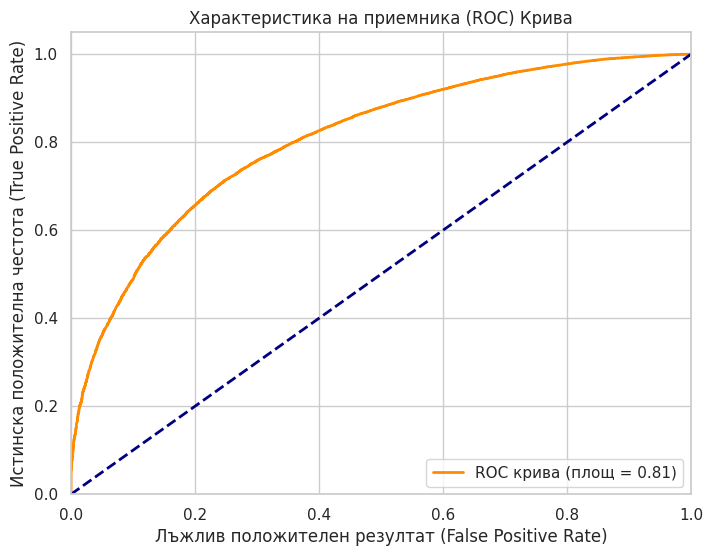

In [197]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Предвиждане на вероятности за тестовия набор
y_scores = model_pipeline.predict_proba(X_test)[:, 1]  # вземете вероятностите за положителния клас

# Изчисляване на ROC крива и площ под кривата (AUC)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Изобразяване на ROC кривата
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC крива (площ = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Лъжлив положителен резултат (False Positive Rate)')
plt.ylabel('Истинска положителна честота (True Positive Rate)')
plt.title('Характеристика на приемника (ROC) Крива')
plt.legend(loc="lower right")
plt.show()


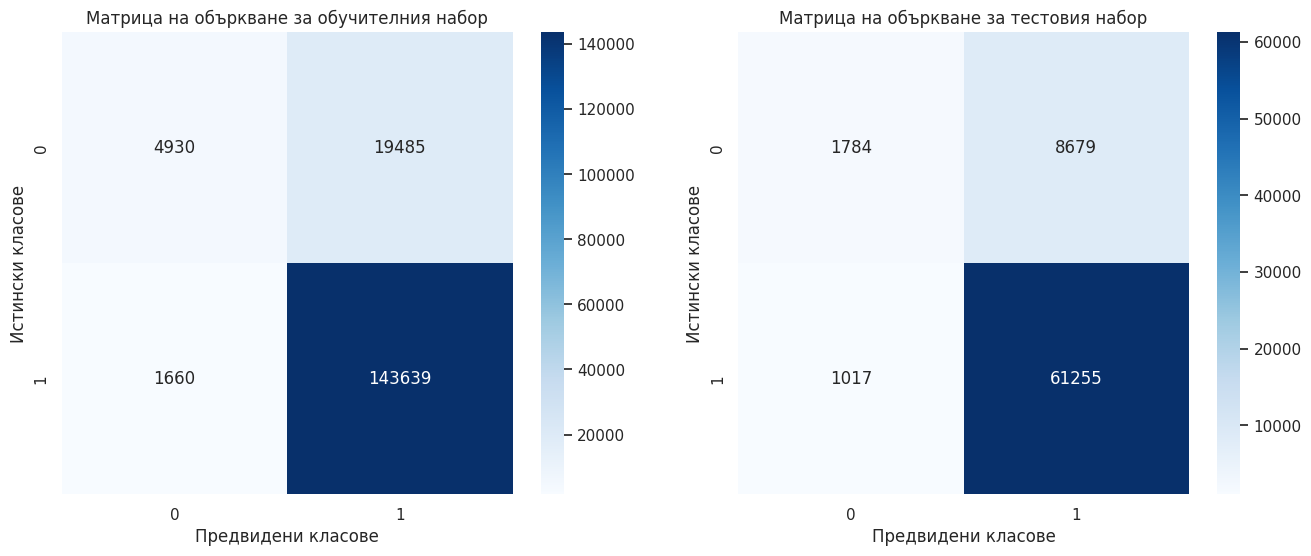

In [198]:

# Предвиждане на маркерите за обучителния набор
y_train_pred = model_pipeline.predict(X_train)

# Изчисляване на матриците на объркване за обучителния и тестовия набор
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_pred)

# Изобразяване на матриците на объркване
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Матрица на объркване за обучителния набор
sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Предвидени класове')
ax[0].set_ylabel('Истински класове')
ax[0].set_title('Матрица на объркване за обучителния набор')

# Матрица на объркване за тестовия набор
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', ax=ax[1])
ax[1].set_xlabel('Предвидени класове')
ax[1].set_ylabel('Истински класове')
ax[1].set_title('Матрица на объркване за тестовия набор')

plt.show()


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.607021 to fit


<Figure size 5000x5000 with 0 Axes>

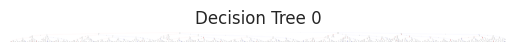

In [199]:
# Get the trained XGBoost model from the pipeline
xgb_model = model_pipeline.named_steps['classifier']

# Plot the decision tree (you can change tree_num to visualize a different tree)
tree_num = 0
plt.figure(figsize=(50, 50))
xgb.plot_tree(xgb_model, num_trees=tree_num)  # rankdir='LR' for left-to-right orientation
plt.title(f'Decision Tree {tree_num}')
plt.show()

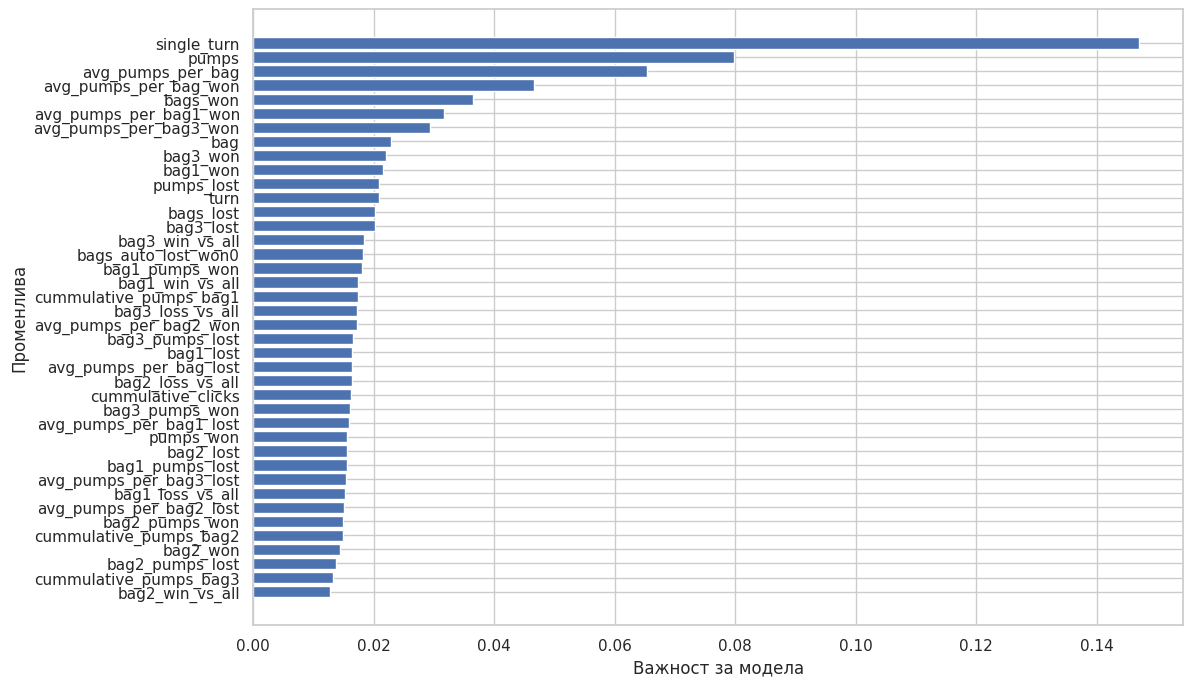

In [200]:

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Feature names (assuming you have them)
feature_names = X_train.columns

# Pair feature names with their corresponding importances
features = list(zip(feature_names, feature_importances))

# Sort the feature importances in descending order
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Unzip into separate lists for plotting
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Create a bar chart of the sorted feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Важност за модела')
plt.ylabel('Променлива')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Model Interpretation

In [201]:
transformed_data['Risk_Probability'] = model_pipeline.predict_proba(X)[:, 1]

In [202]:
# Adjustment Logic:

# If a player risked where others risked as well (high 'Risked' value and high average risk-taking behavior), their risk-taking score should be adjusted downwards to reflect conformity.
# If a player risked where others didn't (high 'Risked' value but low average risk-taking behavior), their score should be adjusted upwards to reflect higher individual risk-taking.
# If a player did not risk where others did not risk (low 'Risked' value and low average risk-taking behavior), their score remains the same.
# If a player did not risk where others risked (low 'Risked' value but high average risk-taking behavior), their score should be adjusted downwards to reflect lower individual risk-taking.
# Implement the Adjustment

In [203]:
# Predict the probabilities for the positive class
y_train_prob = model_pipeline.predict_proba(X_train)[:, 1]  # Assuming the second column is for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)

# Calculate Youden's J statistic
youden_j = tpr - fpr

# Find the optimal threshold
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 0.83853966


In [204]:
def adjust_risk_score_new(row, optimal_threshold = optimal_threshold):
    if row['Risked'] == 1:
        if row['Risk_Probability'] <= optimal_threshold:
            return row['Risk_Probability'] ** 2
        else:
            return row['Risk_Probability']
    else:
        if row['Risk_Probability'] <=optimal_threshold:
            return row['Risk_Probability']
        else:
            return np.sqrt(row['Risk_Probability'])

# Assuming transformed_df is your DataFrame
transformed_data['Adjusted_Risk_Score_New'] = transformed_data.apply(adjust_risk_score_new, axis=1)

# Log transform the 'Risk_Probability' column
transformed_data['Log_Risk_Probability'] = np.log(transformed_data['Risk_Probability'])

### Turns

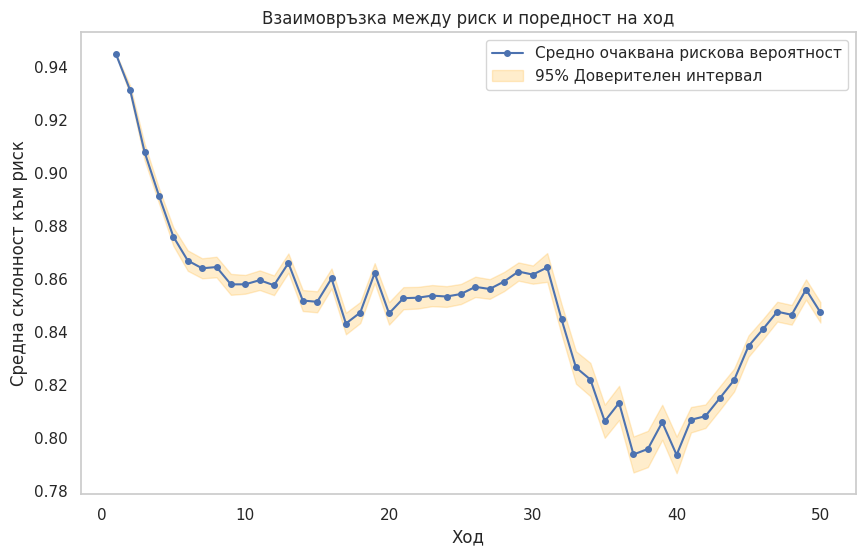

In [205]:
# Group by 'turn' and calculate the mean and confidence interval
grouped = transformed_data.groupby('turn')['Risk_Probability'].agg(['mean', 'sem'])
# Calculate the upper and lower bounds of the confidence interval
grouped['upper_bound'] = grouped['mean'] + 1.96 * grouped['sem']  # 95% confidence interval
grouped['lower_bound'] = grouped['mean'] - 1.96 * grouped['sem']

# Create a shaded area for the confidence interval
plt.figure(figsize=(10, 6))
x = grouped.index  # 'turn' values
y = grouped['mean']  # Mean Risk_Probability values
upper_bound = grouped['upper_bound']
lower_bound = grouped['lower_bound']

plt.plot(x, y, '-o', markersize=4, label='Средно очаквана рискова вероятност')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, label='95% Доверителен интервал', color='orange')
plt.xlabel('Ход')
plt.ylabel('Средна склонност към риск')
plt.title('Взаимовръзка между риск и поредност на ход')
plt.grid(False)
plt.legend()
plt.show()

### Bags

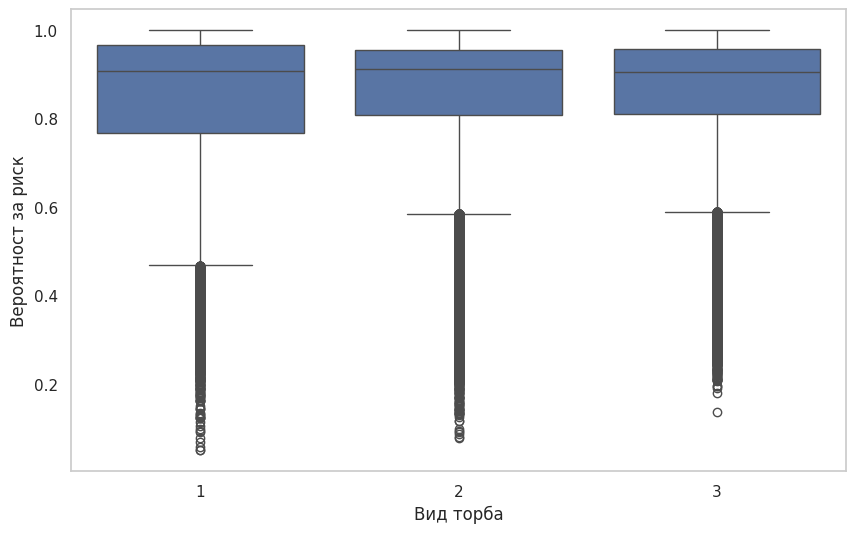

In [206]:
# Create a boxplot per bag
plt.figure(figsize=(10, 6))
sns.boxplot(x='bag', y='Risk_Probability', data=transformed_data)
plt.xlabel('Вид торба')
plt.ylabel('Вероятност за риск')
# plt.title('Boxplot of Risk_Probability per Bag')
plt.grid(False)
plt.show()

### Base Histogram

KS Statistic: 0.11561793855630104
KS p-value: 1.7792054752835268e-13


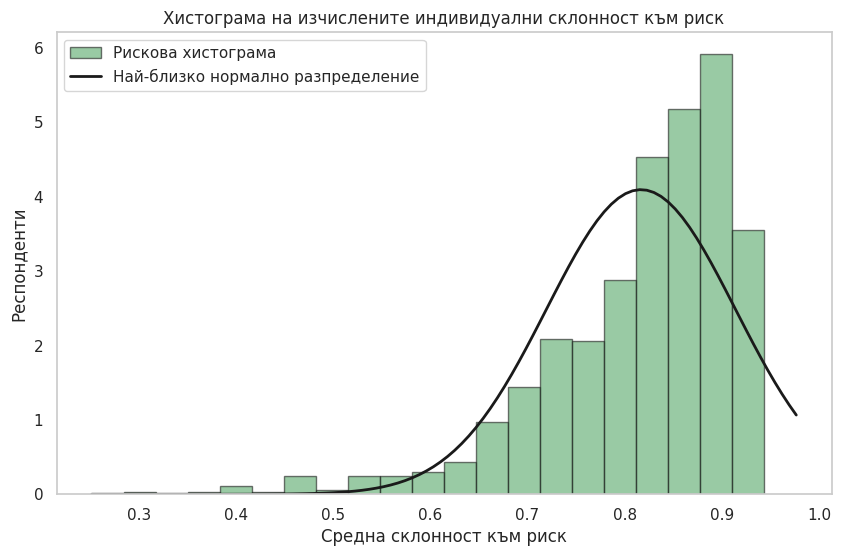

In [207]:
# Calculate the average Risk_Probability per Id
average_risk_by_id = transformed_data.groupby('Id')['Risk_Probability'].apply(lambda x: gmean(x))

# Fit a normal distribution to the data
mu, std = norm.fit(average_risk_by_id)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(average_risk_by_id, bins=20, density=True, alpha=0.6, color='g', edgecolor='k', label='Рискова хистограма')

# Create a PDF (probability density function) using the fitted parameters
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Най-близко нормално разпределение')

plt.xlabel('Средна склонност към риск')
plt.ylabel('Респонденти')
plt.title('Хистограма на изчислените индивидуални склонност към риск')
plt.grid(False)
plt.legend()

# Perform the KS test
ks_statistic, ks_p_value = kstest(average_risk_by_id, 'norm', args=(mu, std))
print(f'KS Statistic: {ks_statistic}')
print(f'KS p-value: {ks_p_value}')

plt.show()

### Base DF joins

In [208]:
df_old = result_df[result_df.Id.isin(transformed_data.Id.unique())].reset_index(drop = False)
df_old

,index,collected_1,collected_2,collected_3,collected_4,collected_5,collected_6,collected_7,collected_8,collected_9,...,bag_42,bag_43,bag_44,bag_45,bag_46,bag_47,bag_48,bag_49,bag_50,Id
0,1,0,3,4,0,2,3,3,4,3,...,2,2,2,2,2,2,2,2,2,1
1,2,0,0,0,0,0,0,0,0,6,...,2,2,2,2,2,2,2,2,2,2
2,3,0,3,4,0,0,2,2,2,2,...,2,2,2,2,2,2,2,2,2,3
3,5,0,2,3,0,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,5
4,6,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1263,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,1263
1114,1265,18,0,10,16,0,0,17,0,0,...,2,2,2,2,2,2,2,2,2,1265
1115,1266,14,0,8,0,9,0,0,0,1,...,2,2,2,2,2,2,2,2,2,1266
1116,1267,1,1,1,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1267


In [209]:
# Create a DataFrame from the Series
average_risk_df = pd.DataFrame({'Id': average_risk_by_id.index, 'Risk_Probability': average_risk_by_id.values})

# Set 'Id' as the index
average_risk_df.set_index('Id', inplace=True)

# Display the resulting DataFrame
average_risk_df.reset_index(drop = False, inplace = True)
average_risk_df.columns = ['index', 'AVG_RISK_PROB']
df_merge  = df_old.merge(average_risk_df, on = 'index', how = 'left')
df_merge['Classic Metric'] = (df_merge.filter(regex = 'collected').sum(axis = 1)) / (df_merge.filter(regex='collected') != 0).astype(int).sum(axis = 1)

In [210]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the 'Classic Metric' column and transform it
df_merge['Scaled_Classic_Metric'] = scaler.fit_transform(df_merge[['Classic Metric']])

In [211]:
df_merge

,index,collected_1,collected_2,collected_3,collected_4,collected_5,collected_6,collected_7,collected_8,collected_9,...,bag_45,bag_46,bag_47,bag_48,bag_49,bag_50,Id,AVG_RISK_PROB,Classic Metric,Scaled_Classic_Metric
0,1,0,3,4,0,2,3,3,4,3,...,2,2,2,2,2,2,1,0.705688,2.577778,0.110125
1,2,0,0,0,0,0,0,0,0,6,...,2,2,2,2,2,2,2,0.864726,8.740741,0.560681
2,3,0,3,4,0,0,2,2,2,2,...,2,2,2,2,2,2,3,0.690596,3.186047,0.154593
3,5,0,2,3,0,2,2,2,2,2,...,2,2,2,2,2,2,5,0.616718,2.772727,0.124377
4,6,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,6,0.882941,6.076923,0.365937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1263,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,1263,0.888781,8.882353,0.571034
1114,1265,18,0,10,16,0,0,17,0,0,...,2,2,2,2,2,2,1265,0.899619,8.863636,0.569665
1115,1266,14,0,8,0,9,0,0,0,1,...,2,2,2,2,2,2,1266,0.799186,4.058824,0.218400
1116,1267,1,1,1,1,2,2,2,2,2,...,2,2,2,2,2,2,1267,0.588225,2.857143,0.130548


In [212]:
from scipy import stats

# Calculate the sample mean and standard deviation
sample_mean = df_merge['Scaled_Classic_Metric'].mean()
sample_std = df_merge['Scaled_Classic_Metric'].std()

# Perform the Kolmogorov-Smirnov test for normality
ks_statistic, p_value = stats.kstest(df_merge['Scaled_Classic_Metric'], 'norm', args=(sample_mean, sample_std))

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {round(p_value,5)}")

KS Statistic: 0.080909213655743
P-value: 0.0


#### Metric Comparison

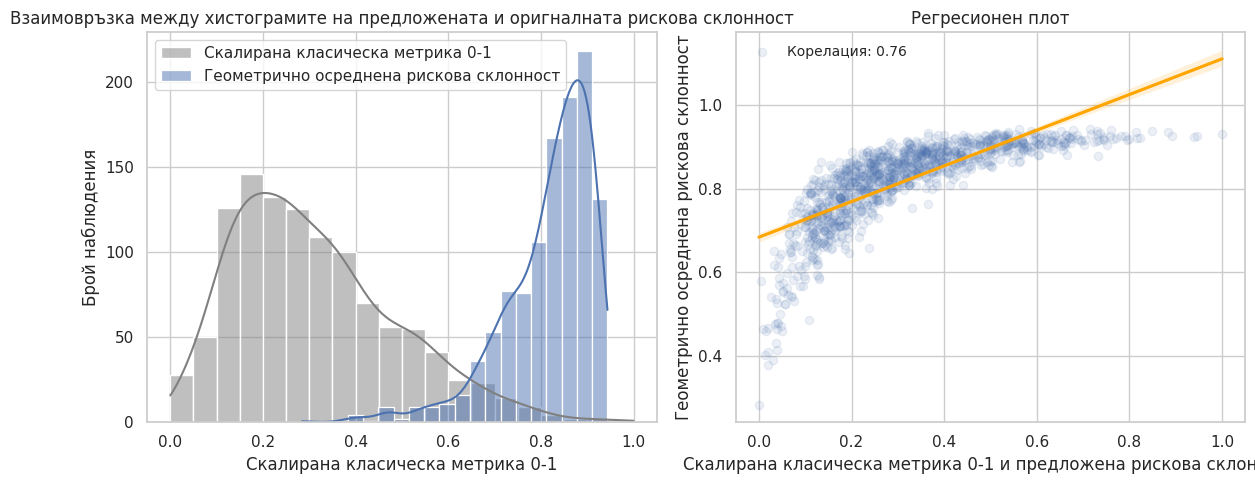

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_merge'
# Load your DataFrame here
# df_merge = pd.read_csv('your_data.csv')

# Scale the "Classic Metric" to a range of 0 to 1
df_merge['Scaled_Classic_Metric'] = (df_merge['Classic Metric'] - df_merge['Classic Metric'].min()) / (df_merge['Classic Metric'].max() - df_merge['Classic Metric'].min())

# Create a figure with a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot both histograms on the same graph (sharing the same axis) in the left subplot
sns.histplot(df_merge['Scaled_Classic_Metric'], bins=20, kde=True, ax=axes[0], color='grey', label='Скалирана класическа метрика 0-1')
sns.histplot(df_merge['AVG_RISK_PROB'], bins=20, kde=True, ax=axes[0], label='Геометрично осреднена рискова склонност')
axes[0].set_title('Взаимовръзка между хистограмите на предложената и оригналната рискова склонност')
axes[0].legend()
axes[0].set_xlabel('Скалирана класическа метрика 0-1')
axes[0].set_ylabel('Брой наблюдения')

# Create a regression plot on the right subplot with a custom line color (orange)
regplot = sns.regplot(x='Scaled_Classic_Metric', y='AVG_RISK_PROB', data=df_merge, ax=axes[1], line_kws={'color': 'orange'}, scatter_kws={'alpha': 0.1})

# Extract the correlation coefficient from the regression plot
correlation_coefficient = df_merge[['Scaled_Classic_Metric', 'AVG_RISK_PROB']].corr().iloc[0, 1]
correlation_text = f'Корелация: {correlation_coefficient:.2f}'

# Add the correlation information to the legend with the orange line
regplot.legend([correlation_text], loc='upper left', fontsize=10, frameon=False)
regplot.set_xlabel('Скалирана класическа метрика 0-1 и предложена рискова склонност')
regplot.set_ylabel('Геометрично осреднена рискова склонност')

axes[1].set_title('Регресионен плот')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


KS Statistic: 0.07275455308240864
KS p-value: 1.3637523505728618e-05


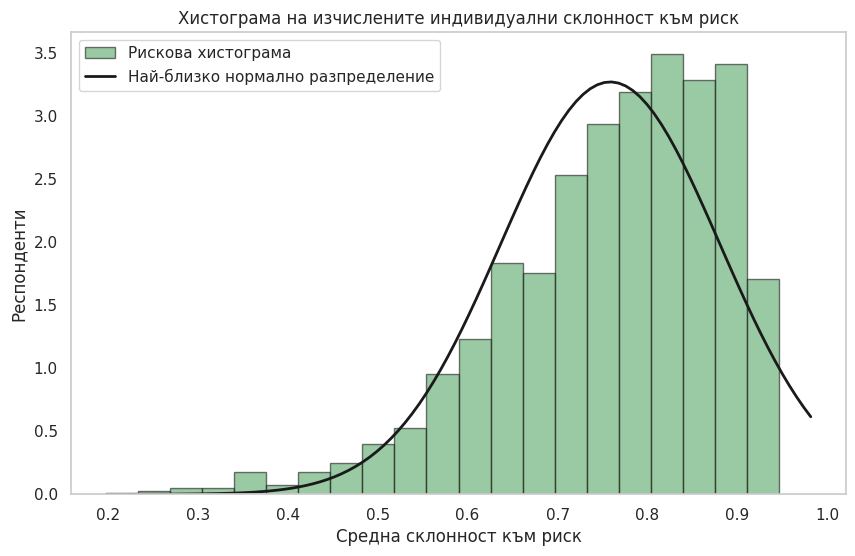

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
import pandas as pd
from scipy.stats import gmean

# Assuming your DataFrame is named 'df'
# Load your DataFrame here
# df = pd.read_csv('your_data.csv')

# Calculate the average Risk_Probability per Id
average_risk_by_id = transformed_data.groupby('Id')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))

# Fit a normal distribution to the data
mu, std = norm.fit(average_risk_by_id)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(average_risk_by_id, bins=20, density=True, alpha=0.6, color='g', edgecolor='k', label='Рискова хистограма')

# Create a PDF (probability density function) using the fitted parameters
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Най-близко нормално разпределение')

plt.xlabel('Средна склонност към риск')
plt.ylabel('Респонденти')
plt.title('Хистограма на изчислените индивидуални склонност към риск')
plt.grid(False)
plt.legend()

# Perform the KS test
ks_statistic, ks_p_value = kstest(average_risk_by_id, 'norm', args=(mu, std))
print(f'KS Statistic: {ks_statistic}')
print(f'KS p-value: {ks_p_value}')

plt.show()


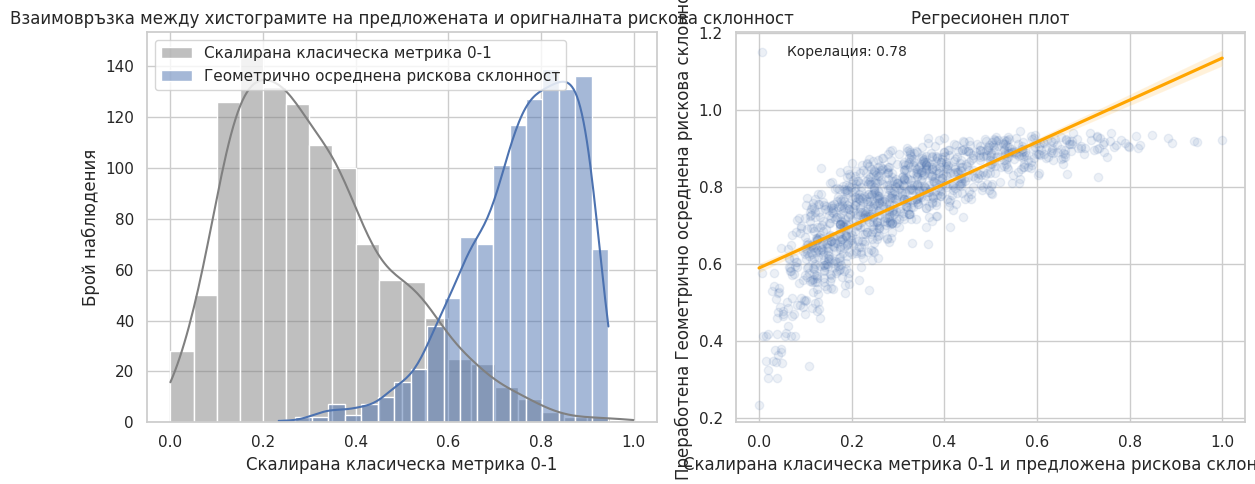

In [215]:


# Assuming you have 'average_risk_by_id' as a Series
# Create a DataFrame from the Series
average_risk_df = pd.DataFrame({'Id': average_risk_by_id.index, 'Adjusted_Risk_Score_New': average_risk_by_id.values})

# Set 'Id' as the index
average_risk_df.set_index('Id', inplace=True)

# Display the resulting DataFrame
average_risk_df.reset_index(drop = False, inplace = True)
average_risk_df.columns = ['index', 'Adjusted_Risk_Score_New']
df_merge  = df_old.merge(average_risk_df, on = 'index', how = 'left')
df_merge['Classic Metric'] = (df_merge.filter(regex = 'collected').sum(axis = 1)) / (df_merge.filter(regex='collected') != 0).astype(int).sum(axis = 1)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df_merge'
# Load your DataFrame here
# df_merge = pd.read_csv('your_data.csv')

# Scale the "Classic Metric" to a range of 0 to 1
df_merge['Scaled_Classic_Metric'] = (df_merge['Classic Metric'] - df_merge['Classic Metric'].min()) / (df_merge['Classic Metric'].max() - df_merge['Classic Metric'].min())

# Create a figure with a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot both histograms on the same graph (sharing the same axis) in the left subplot
sns.histplot(df_merge['Scaled_Classic_Metric'], bins=20, kde=True, ax=axes[0], color='grey', label='Скалирана класическа метрика 0-1')
sns.histplot(df_merge['Adjusted_Risk_Score_New'], bins=20, kde=True, ax=axes[0], label='Геометрично осреднена рискова склонност')
axes[0].set_title('Взаимовръзка между хистограмите на предложената и оригналната рискова склонност')
axes[0].legend()
axes[0].set_xlabel('Скалирана класическа метрика 0-1')
axes[0].set_ylabel('Брой наблюдения')

# Create a regression plot on the right subplot with a custom line color (orange)
regplot = sns.regplot(x='Scaled_Classic_Metric', y='Adjusted_Risk_Score_New', data=df_merge, ax=axes[1], line_kws={'color': 'orange'}, scatter_kws={'alpha': 0.1})

# Extract the correlation coefficient from the regression plot
correlation_coefficient = df_merge[['Scaled_Classic_Metric', 'Adjusted_Risk_Score_New']].corr().iloc[0, 1]
correlation_text = f'Корелация: {correlation_coefficient:.2f}'

# Add the correlation information to the legend with the orange line
regplot.legend([correlation_text], loc='upper left', fontsize=10, frameon=False)
regplot.set_xlabel('Скалирана класическа метрика 0-1 и предложена рискова склонност')
regplot.set_ylabel('Преработена Геометрично осреднена рискова склонност')

axes[1].set_title('Регресионен плот')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [216]:
# Segment the DataFrame
df_turn1_20 = transformed_data[transformed_data['turn'].between(1, 20)]
df_turn21_50 = transformed_data[transformed_data['turn'].between(21, 50)]


# Compute the metrics for each segment
metrics_turn1_20 = df_turn1_20.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()
metrics_turn21_50 = df_turn21_50.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()

# Combine the results
combined_metrics = metrics_turn1_20.join(metrics_turn21_50, lsuffix='_turn1_20', rsuffix='_turn21_50')

<ipython-input-216-548a1d090cab>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  metrics_turn1_20 = df_turn1_20.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()
<ipython-input-216-548a1d090cab>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  metrics_turn21_50 = df_turn21_50.groupby('Id')['Risk_Probability', 'Adjusted_Risk_Score_New'].mean()


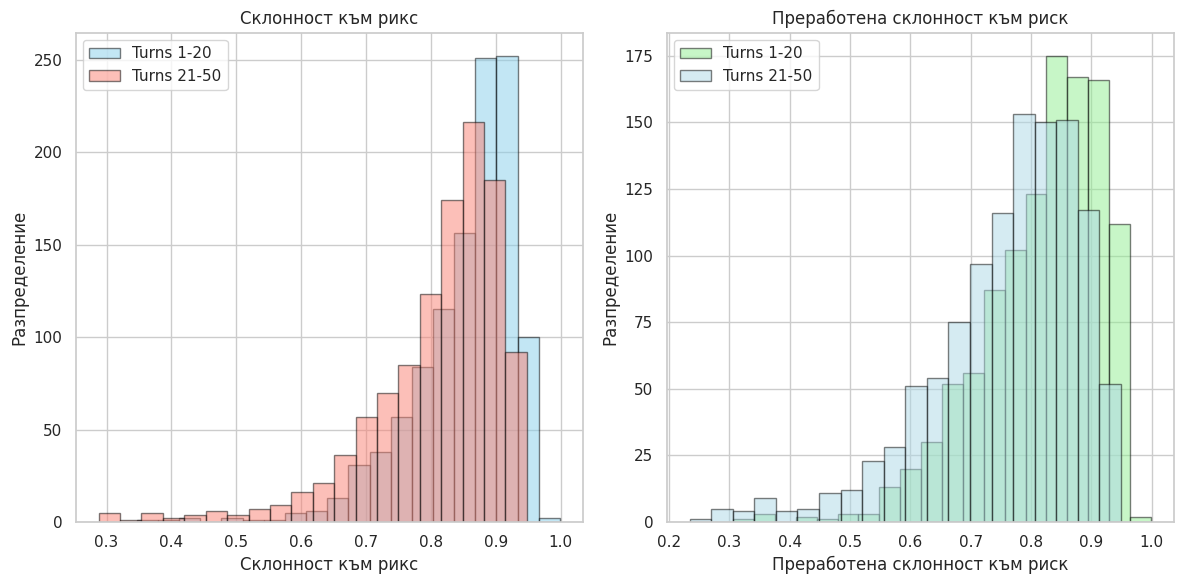

In [217]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms for Risk Probability
axs[0].hist(combined_metrics['Risk_Probability_turn1_20'], bins=20, color='skyblue', edgecolor='black', alpha=0.5, label='Turns 1-20')
axs[0].hist(combined_metrics['Risk_Probability_turn21_50'], bins=20, color='salmon', edgecolor='black', alpha=0.5, label='Turns 21-50')
axs[0].set_title('Склонност към рикс')
axs[0].set_xlabel('Склонност към рикс')
axs[0].set_ylabel('Разпределение')
axs[0].legend()

# Plot histograms for Adjusted Risk Score
axs[1].hist(combined_metrics['Adjusted_Risk_Score_New_turn1_20'], bins=20, color='lightgreen', edgecolor='black', alpha=0.5, label='Turns 1-20')
axs[1].hist(combined_metrics['Adjusted_Risk_Score_New_turn21_50'], bins=20, color='lightblue', edgecolor='black', alpha=0.5, label='Turns 21-50')
axs[1].set_title('Преработена склонност към риск')
axs[1].set_xlabel('Преработена склонност към риск')
axs[1].set_ylabel('Разпределение')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

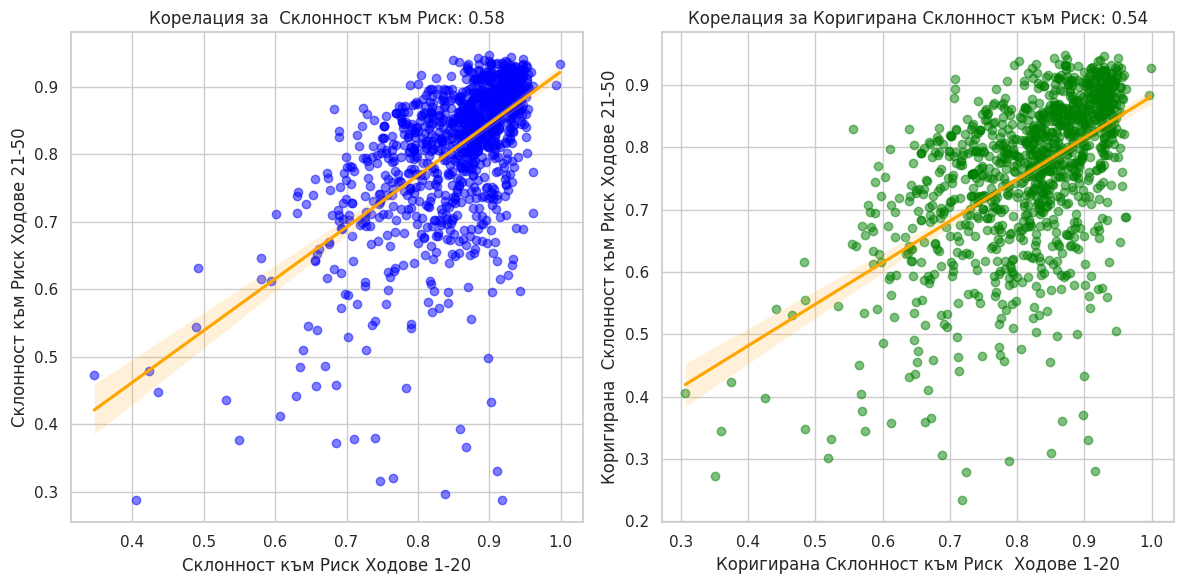

In [218]:
# Изчисляване на корелационни стойности
corr_risk_prob = combined_metrics['Risk_Probability_turn1_20'].corr(combined_metrics['Risk_Probability_turn21_50'])
corr_adj_risk_score = combined_metrics['Adjusted_Risk_Score_New_turn1_20'].corr(combined_metrics['Adjusted_Risk_Score_New_turn21_50'])

# Създаване на 1x2 графики за разсейване с корелационни стойности и оранжеви линии на регресия

# Създаване на графики
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Графика за Риск вероятност с корелация в заглавие и оранжева линия на регресия
sns.regplot(ax=axs[0], x='Risk_Probability_turn1_20', y='Risk_Probability_turn21_50', data=combined_metrics, color='blue', scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'})
axs[0].set_title(f'Корелация за  Склонност към Риск: {corr_risk_prob:.2f}')
axs[0].set_xlabel('Склонност към Риск Ходове 1-20')
axs[0].set_ylabel('Склонност към Риск Ходове 21-50')

# Графика за Коригиран Риск Стойност с корелация в заглавие и оранжева линия на регресия
sns.regplot(ax=axs[1], x='Adjusted_Risk_Score_New_turn1_20', y='Adjusted_Risk_Score_New_turn21_50', data=combined_metrics, color='green', scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'})
axs[1].set_title(f'Корелация за Коригирана Склонност към Риск: {corr_adj_risk_score:.2f}')
axs[1].set_xlabel('Коригиранa Склонност към Риск  Ходове 1-20')
axs[1].set_ylabel('Коригиранa  Склонност към Риск Ходове 21-50')

# Подреди графиките
plt.tight_layout()
plt.show()

In [219]:
# Assuming your DataFrame is named 'df'
# Filter the data for bag 1, bag 2, and bag 3 separately
bag1_data = transformed_data[transformed_data['bag'].astype(int) == 1]
bag2_data = transformed_data[transformed_data['bag'].astype(int) == 2]
bag3_data = transformed_data[transformed_data['bag'].astype(int) == 3]

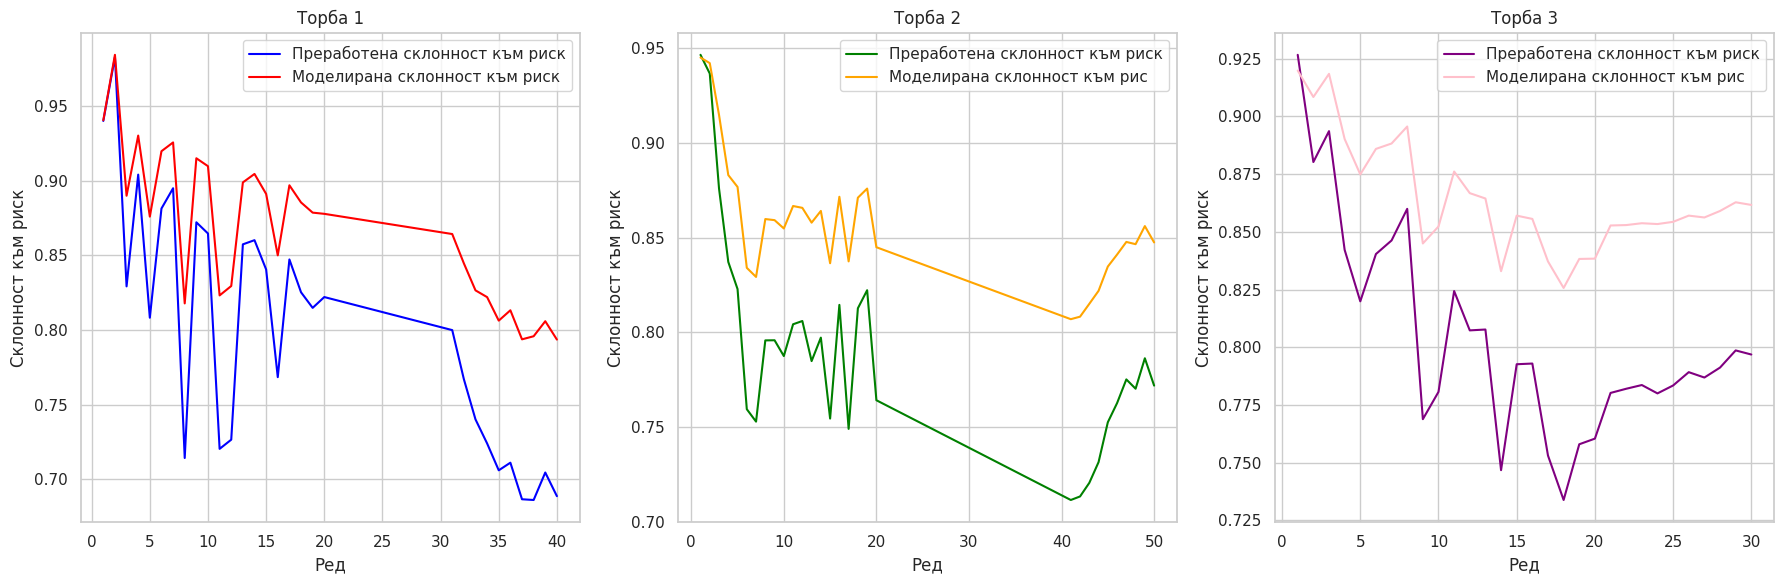

In [220]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate and plot the gmean for Bag 1
gmean_bag1 = bag1_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[0].plot(gmean_bag1.index, gmean_bag1.values, label='Преработена склонност към риск', color='blue')
axes[0].set_xlabel('Ред')
axes[0].set_ylabel('Склонност към риск')
axes[0].set_title('Торба 1')
axes[0].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[0].plot(gmean_bag1.index, bag1_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към риск', color='red')
axes[0].legend(loc='upper right')

# Calculate and plot the gmean for Bag 2
gmean_bag2 = bag2_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[1].plot(gmean_bag2.index, gmean_bag2.values, label='Преработена склонност към риск', color='green')
axes[1].set_xlabel('Ред')
axes[1].set_ylabel('Склонност към риск')
axes[1].set_title('Торба 2')
axes[1].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[1].plot(gmean_bag2.index, bag2_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към рис', color='orange')
axes[1].legend(loc='upper right')

# Calculate and plot the gmean for Bag 3
gmean_bag3 = bag3_data.groupby('turn')['Adjusted_Risk_Score_New'].apply(lambda x: gmean(x))
axes[2].plot(gmean_bag3.index, gmean_bag3.values, label='Преработена склонност към риск', color='purple')
axes[2].set_xlabel('Ред')
axes[2].set_ylabel('Склонност към риск')
axes[2].set_title('Торба 3')
axes[2].legend(loc='upper right')

# Add a line for Risk_Probability (assuming it's a column in your DataFrame)
axes[2].plot(gmean_bag3.index, bag3_data.groupby('turn')['Risk_Probability'].mean(), label='Моделирана склонност към рис', color='pink')
axes[2].legend(loc='upper right')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


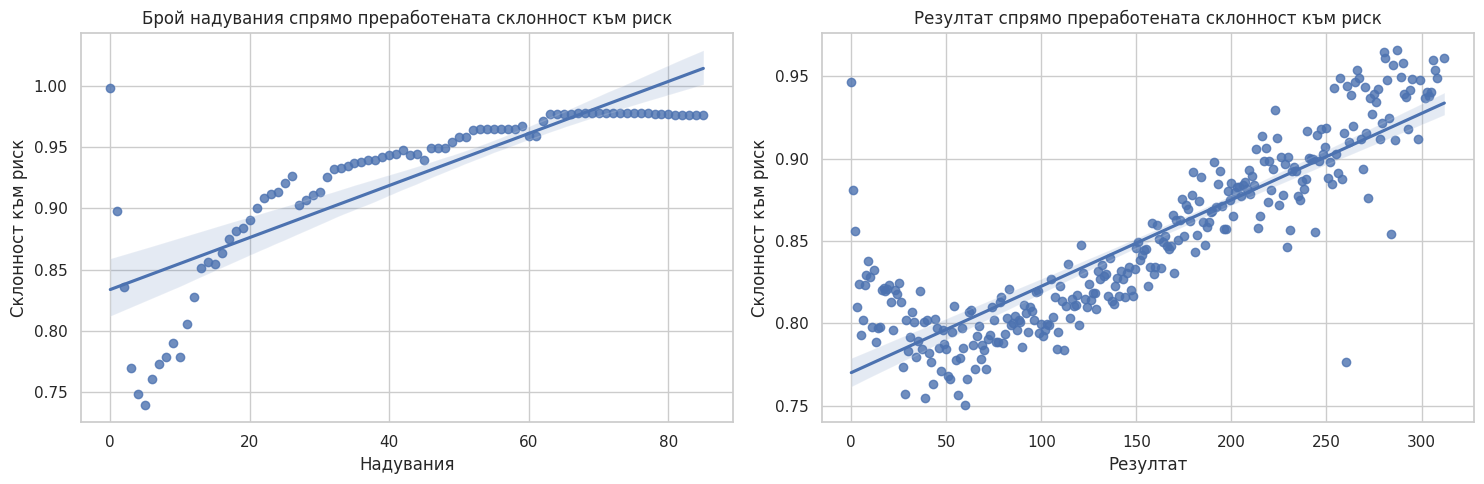

In [221]:
# Assuming your DataFrame is named 'df'
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Group the data by 'pumps' and calculate the geometric mean for 'Adjusted_Risk_Score_New'
aggregated_df = transformed_data.groupby('pumps')['Adjusted_Risk_Score_New'].agg(geo_mean=np.nanmean).reset_index()

# Create the first regplot between 'pumps' and 'Adjusted_Risk_Score_New'
sns.regplot(x="pumps", y="geo_mean", data=aggregated_df, ax=axes[0])
axes[0].set_title("Брой надувания спрямо преработената склонност към риск")
axes[0].set_xlabel("Надувания")
axes[0].set_ylabel("Склонност към риск")

# Group the data by 'total' and calculate the geometric mean for 'Adjusted_Risk_Score_New'
aggregated_df2 = transformed_data.groupby('total')['Adjusted_Risk_Score_New'].agg(geo_mean=np.nanmean).reset_index()

# Create the second regplot between 'total' and 'Adjusted_Risk_Score_New'
sns.regplot(x="total", y="geo_mean", data=aggregated_df2, ax=axes[1])
axes[1].set_title("Резултат спрямо преработената склонност към риск")
axes[1].set_xlabel("Резултат")
axes[1].set_ylabel("Склонност към риск")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()